# Diagnóstico de Series de Tiempo

**Validación estadística de supuestos (Estacionariedad, Estacionalidad, Exógenas) en los datos de series de tiempo**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LIBRERÍAS ESTADÍSTICAS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. CARGA DE DATOS ---
# Asegúrate de ajustar la ruta a tu archivo procesado
ROOT_DIR = "../data/processed/"
FILE_PATH = ROOT_DIR + "tf2_dataset_unificado.csv" # Ejemplo con TF2

print(f"Cargando datos desde: {FILE_PATH} \n")
df = pd.read_csv(FILE_PATH)

# Conversión vital: Texto a Fecha
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha') # Indexar por tiempo es clave en Pandas

# Filtrar últimos 2 años para análisis visual claro (opcional)
# df = df[df.index >= '2022-01-01'] 

print(f"Datos listos: {df.shape[0]} registros desde {df.index.min().date()} hasta {df.index.max().date()}")
# Quitamos columna Average_Players
df = df.drop(columns=['Average Players'])
print(df.head())

Cargando datos desde: ../data/processed/tf2_dataset_unificado.csv 

Datos listos: 7445 registros desde 2007-09-19 hasta 2025-11-30
            jugadores  fin_de_semana  oferta_steam
fecha                                             
2007-09-19       9553              0             0
2007-09-21       5118              1             0
2007-09-22       4616              1             0
2007-09-25       6847              0             0
2007-09-28       6628              1             0


## 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

## 2.1 Visualizamos la serie temporal completa

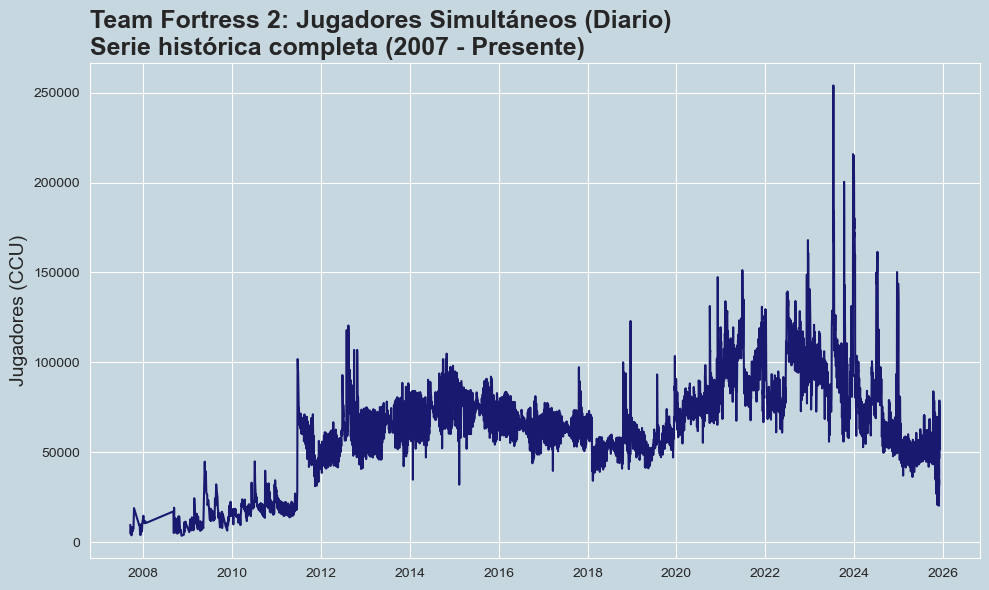

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['axes.facecolor'] = '#c7d7e0'  # Fondo azul claro
plt.rcParams['figure.facecolor'] = '#c7d7e0'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['jugadores'], color='midnightblue')
plt.title("Team Fortress 2: Jugadores Simultáneos (Diario)\nSerie histórica completa (2007 - Presente)", loc='left')
plt.ylabel("Jugadores (CCU)")
plt.xlabel("")
plt.tight_layout()
plt.show()


## 2.2 Verificar frecuencia de los registros

In [17]:
frecuencias = df.index.to_series().diff().value_counts()
print("\nFrecuencia de registros (top 10):")
print(frecuencias.head(10))


Frecuencia de registros (top 10):
fecha
1 days 00:00:00    5723
0 days 00:10:00    1012
0 days 01:00:00     575
5 days 00:00:00      30
2 days 00:00:00      30
4 days 00:00:00      28
3 days 00:00:00      17
6 days 00:00:00      12
7 days 00:00:00       4
8 days 00:00:00       4
Name: count, dtype: int64




>Al parecer la serie de tiempo para `tf2_dataset_unificado.csv` tiene registros principalmente cada 1 día, pero también hay intervalos de 10 minutos, 1 hora, y algunos saltos de varios días. Esto indica que los datos **no son perfectamente diarios; hay registros con diferentes frecuencias**.



## 2.3 LIMPIEZA ROBUSTA DE FRECUENCIA 

In [ ]:
# 1. Resolver Duplicados Diarios (Resampling)
# Si hay 3 registros en un día, tomamos el promedio (mean) o el máximo (max)
# Usaremos 'max' para no suavizar demasiado los picos de jugadores.
df_clean = df.resample('D').max()

# 2. Recorte de Historia (Desde 2017)
# Esto suele eliminar la mayoría de los huecos horribles de 2007-2015
df_clean = df_clean[df_clean.index >= '2017-01-01']

# 3. Tratamiento de Nulos (Gaps)
# Verificamos cuántos huecos quedaron después del recorte
nulos_antes = df_clean['jugadores'].isna().sum()
print(f"Huecos encontrados desde 2017: {nulos_antes}")

# Usamos interpolación lineal (más realista que ffill para series continuas)
df_clean['jugadores'] = df_clean['jugadores'].interpolate(method='time')

# 4. Regenerar Exógenas (Para asegurar que sean 0 o 1 íntegros)
# Al re-samplear, a veces los 0 y 1 se promedian y quedan como 0.5. Mejor recalcularlos.
df_clean['fin_de_semana'] = df_clean.index.dayofweek.isin([4, 5, 6]).astype(int)

# Para las ofertas, como es más complejo recalcular sin la lista, 
# aquí sí es seguro usar ffill redondeado, o asumir 0 si es nulo.
df_clean['oferta_steam'] = df_clean['oferta_steam'].fillna(0).astype(int)

print(f"✅ Datos limpios y regulares: {df_clean.shape[0]} días.")
print(df_clean.head())

Huecos encontrados desde 2017: 0
✅ Datos limpios y regulares: 3256 días.
            jugadores  fin_de_semana  oferta_steam
fecha                                             
2017-01-01    66667.0              1             1
2017-01-02    70441.0              0             1
2017-01-03    61960.0              0             0
2017-01-04    56966.0              0             0
2017-01-05    64057.0              0             0


## 2.4 INSPECCIÓN VISUAL (Descomposición en Componentes) 

Generando descomposición clásica (Aditiva)...


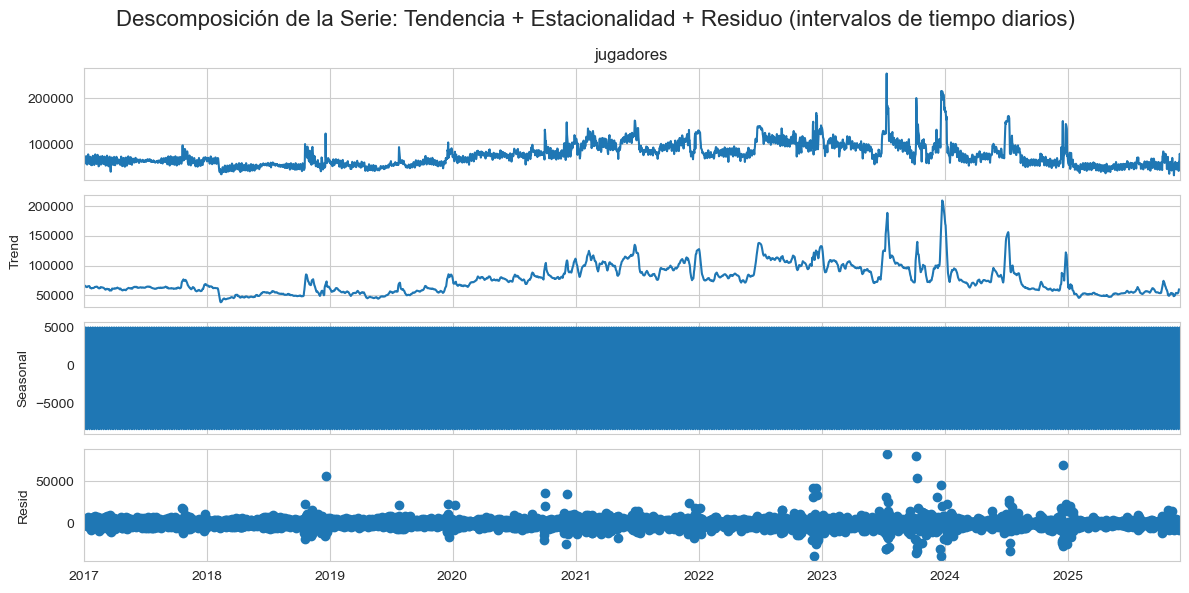

In [ ]:
# Objetivo: Ver si la estacionalidad es obvia al ojo humano

print("Generando descomposición clásica (Aditiva)...")

# frequency=7 indica ciclo semanal
resultado = seasonal_decompose(df_clean['jugadores'], model='additive', period=7)

fig = resultado.plot()
fig.suptitle("Descomposición de la Serie: Tendencia + Estacionalidad + Residuo (intervalos de tiempo diarios)", fontsize=16)
plt.tight_layout()
plt.show()

# Interpretación: Observa el panel 'Seasonal'. ¿Es un patrón repetitivo claro?

### 2.4.1 Zoom en Periodos Específicos (Un Año)

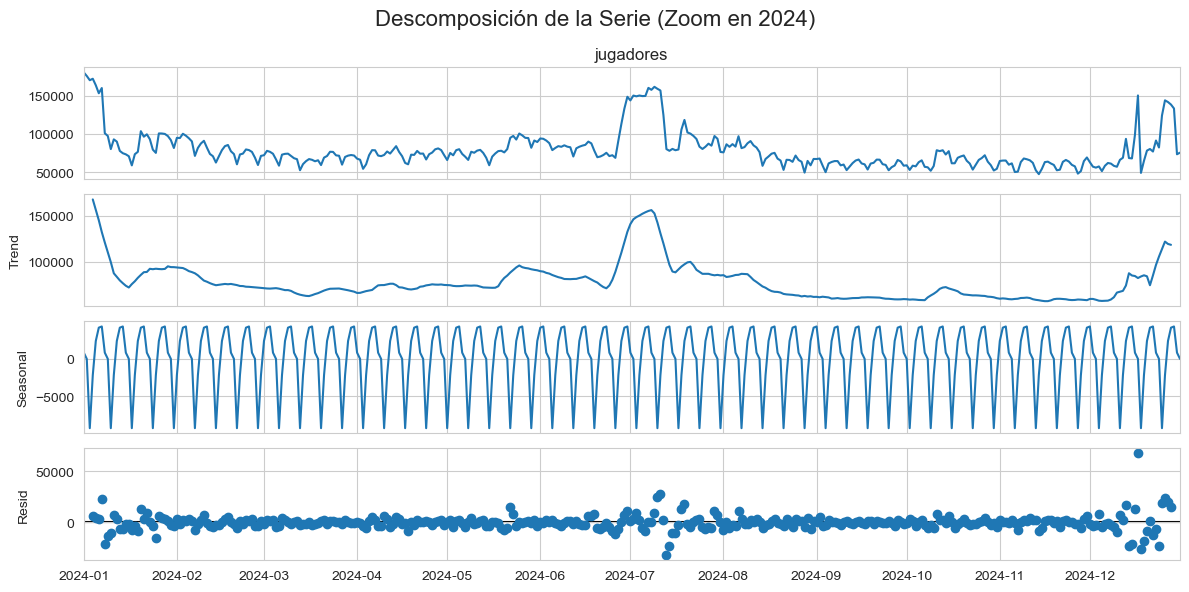

In [5]:
# Selecciona un rango de fechas para hacer zoom (por ejemplo, 2024)
df_zoom = df_clean.loc['2024-01-01':'2024-12-31']

# Descomposición sobre el segmento seleccionado
resultado = seasonal_decompose(df_zoom['jugadores'], model='additive', period=7)

fig = resultado.plot()
fig.suptitle("Descomposición de la Serie (Zoom en 2024)", fontsize=16)
plt.tight_layout()
plt.show()

## 3. PRUEBAS DE ESTACIONARIEDAD Y ESTACIONALIDAD

### 3.1  VALIDACIÓN DE VARIABLES EXÓGENAS (Utilizando Boxplots) 

**Objetivo**: Demostrar estadísticamente que `Fin de Semana` y `Ofertas` importan.

**Interpretación**: Si las medianas (líneas dentro de la caja) están a alturas diferentes, la variable es significativa.

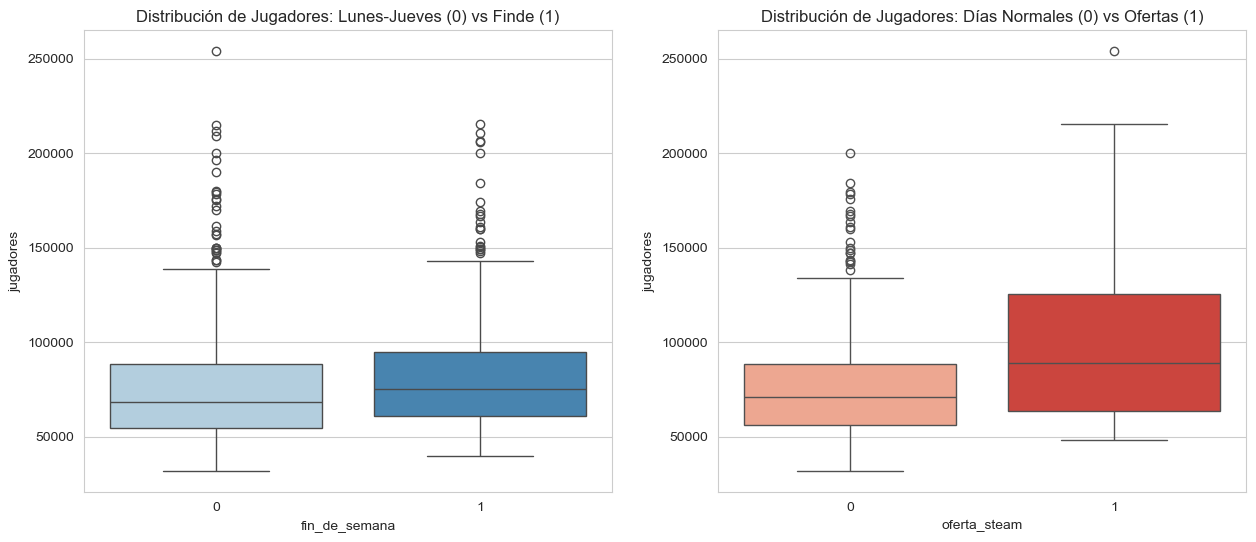

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Impacto del Fin de Semana
sns.boxplot(data=df_clean, x='fin_de_semana', y='jugadores', hue='fin_de_semana', ax=axes[0], palette="Blues", legend=False)
axes[0].set_title("Distribución de Jugadores: Lunes-Jueves (0) vs Finde (1)")

# Gráfico 2: Impacto de Ofertas
sns.boxplot(data=df_clean, x='oferta_steam', y='jugadores', hue='oferta_steam', ax=axes[1], palette="Reds", legend=False)
axes[1].set_title("Distribución de Jugadores: Días Normales (0) vs Ofertas (1)")
plt.show()

### 3.2 PRUEBA DE DICKEY-FULLER AUMENTADA (ADF) PARA ESTACIONARIEDAD

**Objetivo**: Evaluar si la serie de tiempo es estacionaria y decidir si necesitamos diferenciarla ($d=1$)

In [ ]:
print("Ejecutando prueba de Dickey-Fuller Aumentada (ADF)...")

def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'Estadístico ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
        
    if result[1] <= 0.05:
        print("Resultado: Rechazamos H0 -> La serie es ESTACIONARIA.")
    else:
        print("Resultado: No rechazamos H0 -> La serie NO es estacionaria (Necesita d=1).")

# Probamos con la serie original
print("\n--- Serie Original ---")
test_stationarity(df_clean['jugadores'])

# Probamos con la Primera Diferencia (simulando d=1)
print("\n--- Primera Diferencia (d=1) ---")
df_clean['diff_jugadores'] = df_clean['jugadores'].diff()
test_stationarity(df_clean['diff_jugadores'])

Ejecutando prueba de Dickey-Fuller Aumentada (ADF)...

--- Serie Original ---
Estadístico ADF: -3.8570
p-value: 0.0024
Valores Críticos:
   1%: -3.4324
   5%: -2.8624
   10%: -2.5672
Resultado: Rechazamos H0 -> La serie es ESTACIONARIA.

--- Primera Diferencia (d=1) ---
Estadístico ADF: -14.2683
p-value: 0.0000
Valores Críticos:
   1%: -3.4324
   5%: -2.8624
   10%: -2.5672
Resultado: Rechazamos H0 -> La serie es ESTACIONARIA.


### 3.3 IDENTIFICACIÓN DE ÓRDENES (ACF y PACF) 

**Objetivo**: Encontrar $p$ y $q$. Validar el modelo $(1,1,1)$.

**Interpretación**:
- Busca picos que se salgan de la sombra azul (intervalo de confianza).
- Fíjate si hay un pico recurrente cada 7 lags (Estacionalidad).

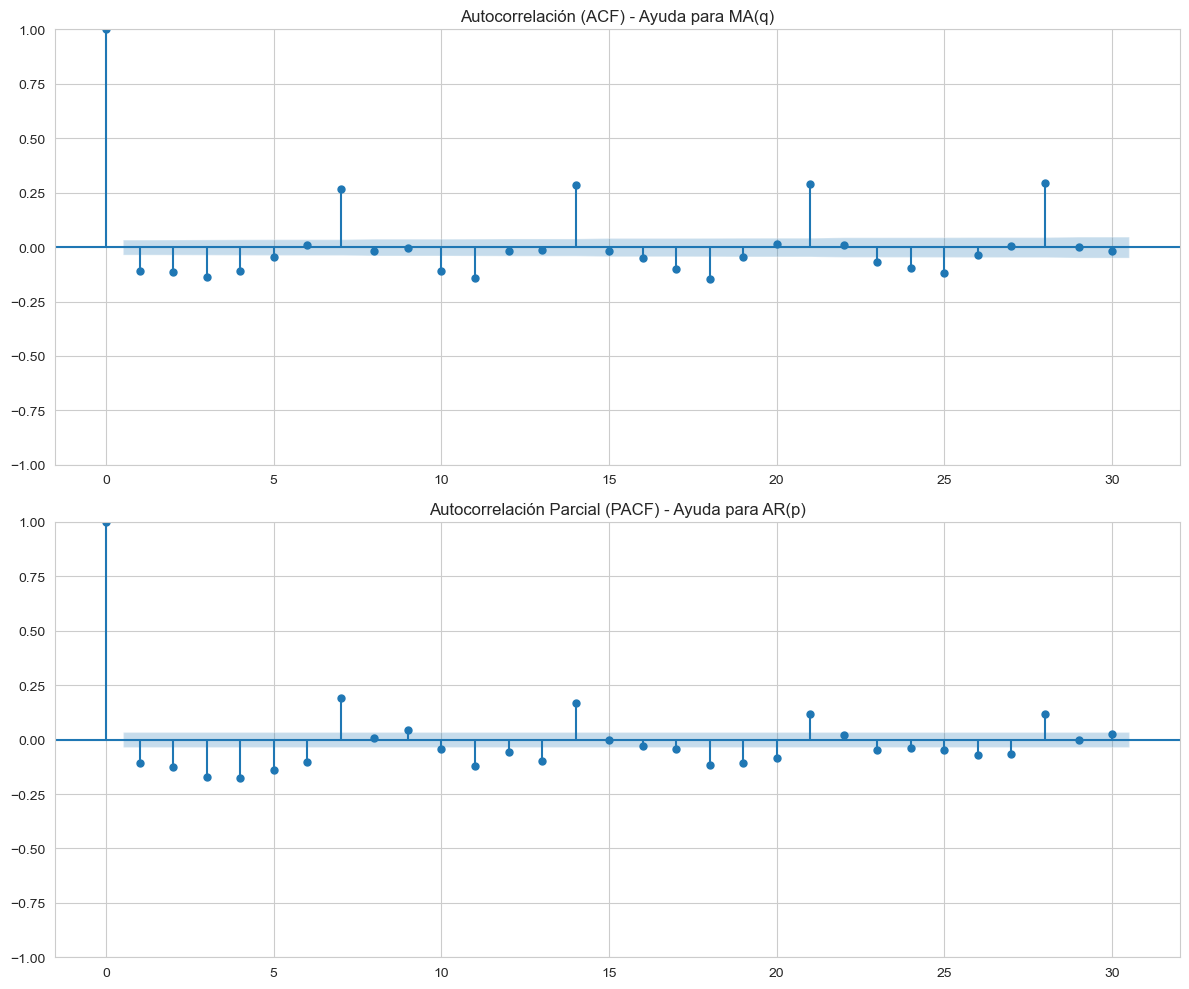

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Usamos la serie diferenciada (porque asumimos que d=1 es necesario)
# dropna() es vital porque la diferenciación crea un NaN al inicio
series_to_plot = df_clean['diff_jugadores'].dropna()

# ACF: Ayuda a identificar q (MA)
plot_acf(series_to_plot, lags=30, ax=ax[0], title="Autocorrelación (ACF) - Ayuda para MA(q)")

# PACF: Ayuda a identificar p (AR)
plot_pacf(series_to_plot, lags=30, ax=ax[1], title="Autocorrelación Parcial (PACF) - Ayuda para AR(p)")

plt.tight_layout()
plt.show()